## Rouge Analysis
In this notebook we want to analyis possible performance levels for extractive summarization.
* number of necessary sentences in gold label
* highest possible rouge score per verdict (based on extracting sentences, 1-grams, 2-grams,...)

In [1]:
%matplotlib inline

import sys
sys.path.append("..")
from pathlib import Path
import pickle
import os, io
from collections import defaultdict

from tqdm import tqdm
import numpy as np
import seaborn as sns

from preprocessing import Tokenizer

In [2]:
tok = Tokenizer(Path("..")/".."/"model")
DATA_PATH = Path("..")/".."/"data"/"dataset"

We now will analyse with how many sentence the guiding principle overlaps with. This gives us an estimate on how many sentences could be picked when assigning greedy targets.

In [3]:
# Contains list of tuples with the (num sentences overlapping with the guiding principles, length verdict body)
with open(Path("rouge_counts.pkl"), "rb") as f:
    sentences = pickle.load(f)

In [4]:
overlaps = np.array(list(map(lambda x: x[0], sentences)))
lengths = np.array(list(map(lambda x: x[1], sentences)))

In [5]:
max_overlap = np.max(overlaps)
min_overlap = np.min(overlaps)
avg_overlap = np.average(overlaps)
median_overlap = np.median(overlaps)

In [6]:
print("Number of sentences overlapping via 2-grams with the guiding principle")
print("Max:", max_overlap, "; Min:", min_overlap, "; Avg:", avg_overlap, "; Median:", median_overlap)

Number of sentences overlapping via 2-grams with the guiding principle
Max: 1267 ; Min: 0 ; Avg: 32.67315338354878 ; Median: 22.0


To bring this in relation: average number of sentences found in guiding principles is ~ 3; i.e. in a greedy selection this would result in a summarization ten times the wanted size.

In [7]:
percentages = overlaps/lengths

In [8]:
max_percentage = np.max(percentages)
min_percentage = np.min(percentages)
avg_percentage = np.average(percentages)
median_percentage = np.median(percentages)

In [9]:
print("Percentage of sentences overlapping via 2-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)

Percentage of sentences overlapping via 2-grams with the guiding principle
Max: 1.0 ; Min: 0.0 ; Avg: 0.3010244944790444 ; Median: 0.2857142857142857


In [10]:
high_verdicts = np.where(percentages>=0.9)
low_verdicts = np.where(percentages<=0.01)
high_verdicts[0]

array([ 1283,  2903, 11999, 12331, 14525, 16293, 24148, 25280, 29829,
       39456, 48325, 48391, 48478, 50542, 51521, 52956, 54897, 56584,
       57511, 58462, 58495, 61203, 61386, 61412, 61466, 61510, 61834,
       61936, 62366, 68927, 68959, 69651, 70968, 71760, 75879, 76355,
       79097, 87906, 93956, 99381], dtype=int64)

In [11]:
print("Verdicts on the extreme overlap sides:")
print("High overlap:", high_verdicts[0].shape[0], "; Low overlap:", low_verdicts[0].shape[0])
testing_verdicts = np.hstack([high_verdicts[0], low_verdicts[0]])

Verdicts on the extreme overlap sides:
High overlap: 40 ; Low overlap: 1150


Text(0.5, 1.0, 'Accumulation of overlap percentages')

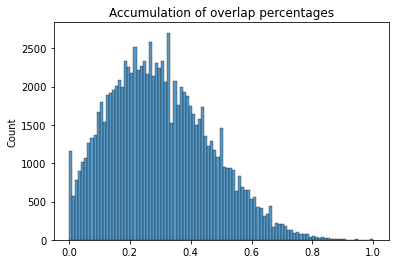

In [12]:
sns.histplot(percentages).set_title("Accumulation of overlap percentages")

In [13]:
# We now want to map the indices back to the verdicts
testing_set = set()
for ind in testing_verdicts:
    testing_set.add(ind)

In [14]:
if False:
    files = []
    for i, file in enumerate(os.listdir(DATA_PATH)):
        if i in testing_set:
            files.append(file)

In [15]:
if False:
    with io.open(Path("filter_verdicts.txt"), "w+", encoding="utf-8") as f:
        for file in files:
            f.write(file+"\n")

## Rouge Performance
We now want to investigate what the possible ROUGE performance levels are for various selection strategies:
* extractive sentences (same number as in guiding principle)
* extractive sentences (greedy; i.e. take as many sentences as necessary)
* extractive words

### Extractive words/n-grams

In [3]:
possible = []
for file in tqdm(os.listdir(DATA_PATH)):
    verdict = tok.tokenize_verdict(DATA_PATH/file)
    wanted_tokens = defaultdict(int)
    found = set()
    for sent in verdict["guiding_principle"]:
        for token in sent:
            wanted_tokens[token] += 1
    
    for sent in verdict["facts"]:
        for token in sent:
            if token in wanted_tokens:
                found.add(token)
    
    for sent in verdict["reasoning"]:
        for token in sent:
            if token in wanted_tokens:
                found.add(token)
                
    found_count = 0
    total_count = 0
    for token in wanted_tokens:
        if token in found:
            found_count += wanted_tokens[token]
        total_count += wanted_tokens[token]
    possible.append((found_count, total_count))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100018/100018 [21:37<00:00, 77.11it/s]


In [4]:
found = np.array(list(map(lambda x: x[0], possible)))
total = np.array(list(map(lambda x: x[1], possible)))
percentage = found/total

In [5]:
max_percentage = np.max(percentage)
min_percentage = np.min(percentage)
avg_percentage = np.average(percentage)
median_percentage = np.median(percentage)

In [6]:
print("Percentage of sentences overlapping via 1-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)

Percentage of sentences overlapping via 1-grams with the guiding principle
Max: 1.0 ; Min: 0.058823529411764705 ; Avg: 0.9039198622423146 ; Median: 0.926829268292683


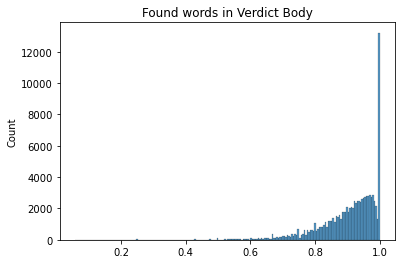

In [7]:
_ = sns.histplot(percentage).set_title("Found words in Verdict Body")

In [8]:
grams = [2,3,4,5]
possible = {
    2: [],
    3: [],
    4: [],
    5: []
}
for file in tqdm(os.listdir(DATA_PATH)):
    verdict = tok.tokenize_verdict(DATA_PATH/file)
    for g in grams:
        wanted_tokens = {}
        found = set()
        for sent in verdict["guiding_principle"]:
            for tok_index in range(len(sent)-g+1):
                gram = tuple(sent[tok_index:tok_index+g])
                if gram in wanted_tokens:
                    wanted_tokens[gram] += 1
                else:
                    wanted_tokens[gram] = 1

        for sent in verdict["facts"]:
            for tok_index in range(len(sent)-g+1):
                gram = tuple(sent[tok_index:tok_index+g])
                if gram in wanted_tokens:
                    found.add(gram)

        for sent in verdict["reasoning"]:
            for tok_index in range(len(sent)-g+1):
                gram = tuple(sent[tok_index:tok_index+g])
                if gram in wanted_tokens:
                    found.add(gram)

        found_count = 0
        total_count = 0
        for gram in wanted_tokens:
            if gram in found:
                found_count += wanted_tokens[gram]
            total_count += wanted_tokens[gram]
        try:
            assert total_count > 0, str(file)+" "+str(g)
            possible[g].append((found_count, total_count))
        except:
            # In this case the guiding principle has less words than we are having grams (i.e. length gp = 4 <-> 5-gram)
            pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100018/100018 [26:00<00:00, 64.07it/s]


2-Grams

Percentage of sentences overlapping via 2-grams with the guiding principle
Max: 1.0 ; Min: 0.0 ; Avg: 0.5899602792316565 ; Median: 0.5948275862068966


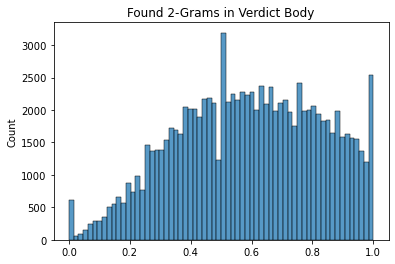

In [9]:
g=2
found = np.array(list(map(lambda x: x[0], possible[g])))
total = np.array(list(map(lambda x: x[1], possible[g])))
percentage = found/total
max_percentage = np.max(percentage)
min_percentage = np.min(percentage)
avg_percentage = np.average(percentage)
median_percentage = np.median(percentage)
print("Percentage of sentences overlapping via "+str(2)+"-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)
_ = sns.histplot(percentage).set_title("Found 2-Grams in Verdict Body")

3-Grams

Percentage of sentences overlapping via 3-grams with the guiding principle
Max: 1.0 ; Min: 0.0 ; Avg: 0.4245674644964678 ; Median: 0.38961038961038963


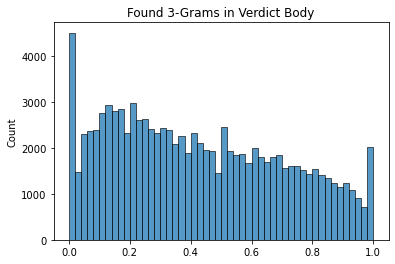

In [10]:
g=3
found = np.array(list(map(lambda x: x[0], possible[g])))
total = np.array(list(map(lambda x: x[1], possible[g])))
percentage = found/total
max_percentage = np.max(percentage)
min_percentage = np.min(percentage)
avg_percentage = np.average(percentage)
median_percentage = np.median(percentage)
print("Percentage of sentences overlapping via "+str(g)+"-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)
_ = sns.histplot(percentage).set_title("Found 3-Grams in Verdict Body")

4-Grams

Percentage of sentences overlapping via 4-grams with the guiding principle
Max: 1.0 ; Min: 0.0 ; Avg: 0.34723353024343007 ; Median: 0.2857142857142857


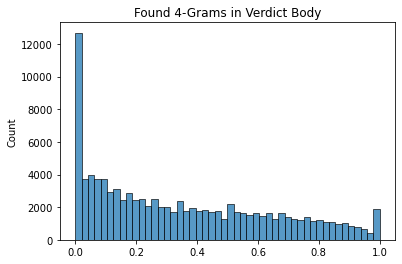

In [11]:
g=4
found = np.array(list(map(lambda x: x[0], possible[g])))
total = np.array(list(map(lambda x: x[1], possible[g])))
percentage = found/total
max_percentage = np.max(percentage)
min_percentage = np.min(percentage)
avg_percentage = np.average(percentage)
median_percentage = np.median(percentage)
print("Percentage of sentences overlapping via "+str(g)+"-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)
_ = sns.histplot(percentage).set_title("Found 4-Grams in Verdict Body")

5-Grams

Percentage of sentences overlapping via 5-grams with the guiding principle
Max: 1.0 ; Min: 0.0 ; Avg: 0.3000715869558675 ; Median: 0.21428571428571427


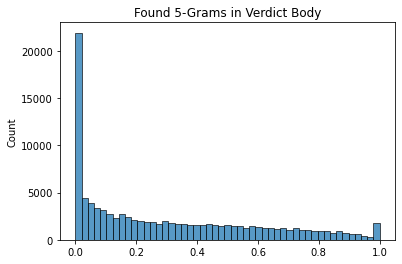

In [12]:
g=5
found = np.array(list(map(lambda x: x[0], possible[g])))
total = np.array(list(map(lambda x: x[1], possible[g])))
percentage = found/total
max_percentage = np.max(percentage)
min_percentage = np.min(percentage)
avg_percentage = np.average(percentage)
median_percentage = np.median(percentage)
print("Percentage of sentences overlapping via "+str(g)+"-grams with the guiding principle")
print("Max:", max_percentage, "; Min:", min_percentage, "; Avg:", avg_percentage, "; Median:", median_percentage)
_ = sns.histplot(percentage).set_title("Found 5-Grams in Verdict Body")

### Extractive Sentences (Same Number)

In [3]:
with open(Path("misc_data")/"same_scores1.pkl", "rb") as f:
    scores = pickle.load(f)
with open(Path("misc_data")/"same_scores2.pkl", "rb") as f:
    scores += pickle.load(f)

In [4]:
rouge_1 = [x["rouge-1"] for x in scores]
rouge_2 = [x["rouge-2"] for x in scores]
rouge_l = [x["rouge-l"] for x in scores]

Rouge-1

Average: 0.5542833081780895


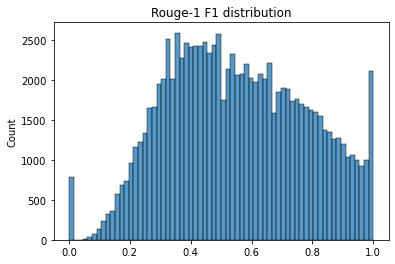

In [5]:
data = [x["f"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.5696315694922568


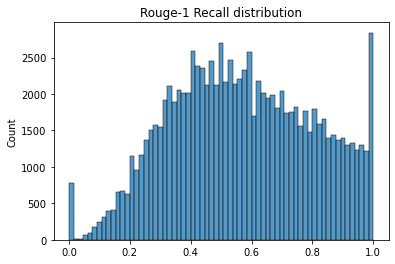

In [6]:
data = [x["r"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.5759485586311373


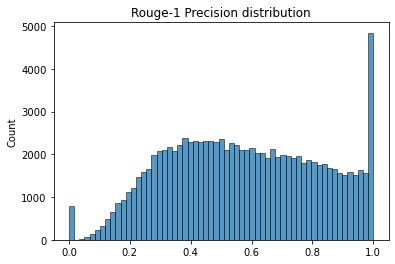

In [7]:
data = [x["p"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 Precision distribution")
print("Average:", sum(data)/len(data))

Rouge-2

Average: 0.4083283964957015


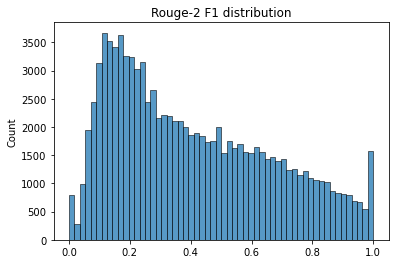

In [8]:
data = [x["f"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.418384729141203


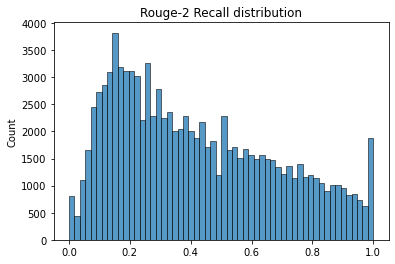

In [9]:
data = [x["r"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.4240501826452001


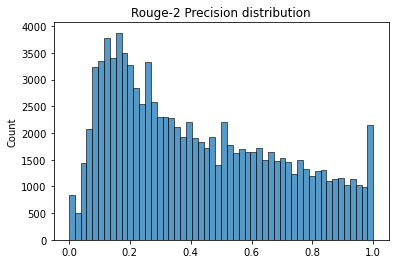

In [10]:
data = [x["p"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 Precision distribution")
print("Average:", sum(data)/len(data))

Rouge-l

Average: 0.5212327363367877


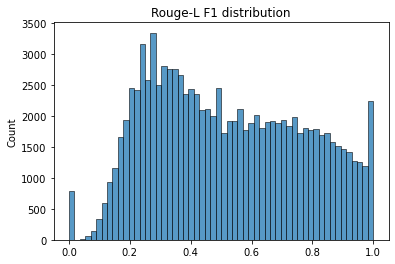

In [11]:
data = [x["f"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.5343071394705898


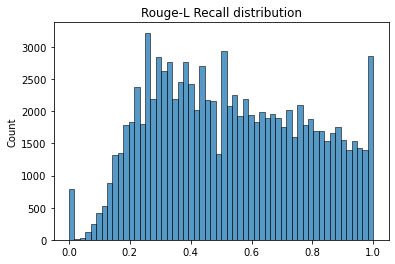

In [12]:
data = [x["r"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.534547532013509


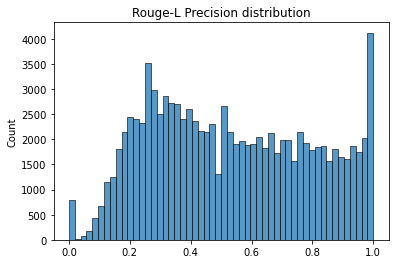

In [13]:
data = [x["p"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L Precision distribution")
print("Average:", sum(data)/len(data))

Summary: Highest possible performance with this method
* 55.43 Rouge-1
* 40.83 Rouge-2
* 52.12 Rouge-L

### Extractive Summarization (Greedy)

In [3]:
GREEDY_PATH = Path("..")/".."/"data"/"databases"/"extractive_greedy.db"
from evaluation import evaluate_indices
import sqlite3

In [4]:
# Had to copy it here due to relative imports
def get_greedy_target_indices(verdict: Path, db_path: Path, tok: Tokenizer):
    file_name = verdict.name
    # We will use sqlite, as it is pretty easy to integrate + port to other machines
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    tok_type = 1
    
    cursor.execute("select section, ind from labels where name=:file and tokenizer=:tok ;", {"file": file_name, "tok": tok_type})
    res = cursor.fetchall()
    facts = []
    reasoning = []
    for row in res:
        if row[0] == 0:
            facts.append(row[1])
        else:
            reasoning.append(row[1])

    conn.close()
    return (facts, reasoning)

In [6]:
scores = []
lengths = []
files = os.listdir(DATA_PATH)
del files[12139] # 1AZR17911.json
del files[67533] # OLG-ST_071822.json
del files[95541]
# We have to remove some files, as those cannot be evaluated with Rouge-L (recusion depth to deep)
for filename in tqdm(files):
    verdict = tok.tokenize_verdict(DATA_PATH/filename)
    gp = [j for i in verdict["guiding_principle"] for j in i]
    indices = get_greedy_target_indices(DATA_PATH/filename, GREEDY_PATH, tok)
    sentences = []
    for f in indices[0]:
        sentences.append(verdict["facts"][f])
    for r in indices[1]:
        sentences.append(verdict["reasoning"][r])
        
    sentences = [j for i in sentences for j in i]
    if len(sentences) == 0:
        sentences = [0]
    score = evaluate_indices([gp], [sentences])
    scores.append(score[0])
    lengths.append((len(gp), len(sentences)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100015/100015 [53:52<00:00, 30.94it/s]


In [10]:
rouge_1 = [x["rouge-1"] for x in scores]
rouge_2 = [x["rouge-2"] for x in scores]
rouge_l = [x["rouge-l"] for x in scores]

Rouge-1

Average: 0.38662733475934336


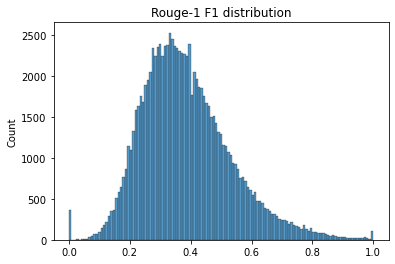

In [11]:
data = [x["f"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.2811604169544823


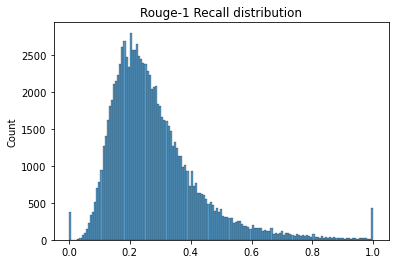

In [12]:
data = [x["r"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.7490593681644576


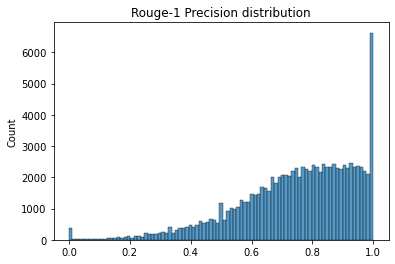

In [13]:
data = [x["p"] for x in rouge_1]
ax = sns.histplot(data)
ax.set_title("Rouge-1 Precision distribution")
print("Average:", sum(data)/len(data))

Rouge-2

Average: 0.2663459064805344


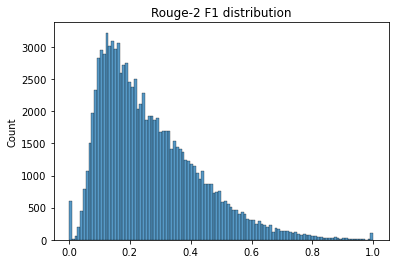

In [14]:
data = [x["f"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.19256936343870262


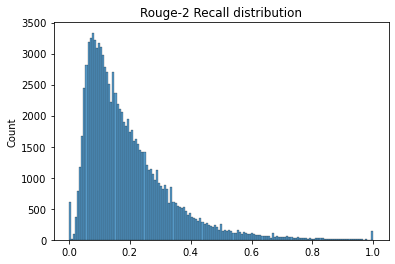

In [15]:
data = [x["r"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.5167740580298795


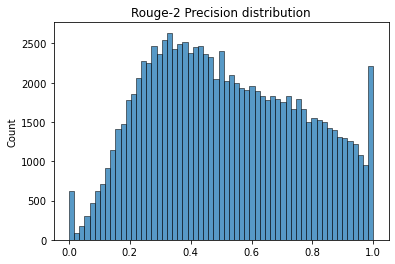

In [16]:
data = [x["p"] for x in rouge_2]
ax = sns.histplot(data)
ax.set_title("Rouge-2 Precision distribution")
print("Average:", sum(data)/len(data))

Rouge-L

Average: 0.3597586670546841


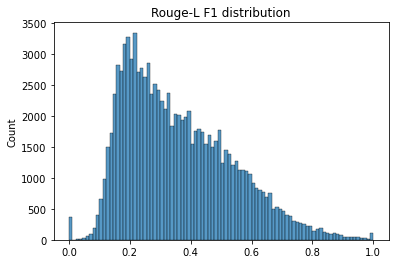

In [17]:
data = [x["f"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L F1 distribution")
print("Average:", sum(data)/len(data))

Average: 0.27621159204377377


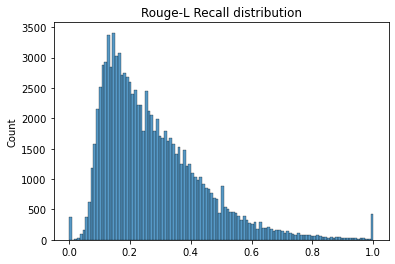

In [18]:
data = [x["r"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L Recall distribution")
print("Average:", sum(data)/len(data))

Average: 0.5835513723343079


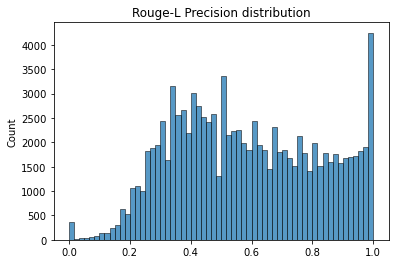

In [19]:
data = [x["p"] for x in rouge_l]
ax = sns.histplot(data)
ax.set_title("Rouge-L Precision distribution")
print("Average:", sum(data)/len(data))

Summary: Highest possible performance with this method
* 38.66 Rouge-1
* 26.63 Rouge-2
* 35.97 Rouge-L

This method for choosing gold targets is at least 10.0 points worse than choosing the exact number of sentences as in the Guiding Principle. This is somewhat unexpected, as this score could have easily been higher. It seems that a greedy selection is far from the optimal selection.

#### Length analysis (Greedy)
We also want to investigate, how much longer a greedy selection of sentences is compared to the wanted summarization length.

In [20]:
length_diff = list(map(lambda x: x[1]-x[0], lengths))

Text(0.5, 0, 'Tokens')

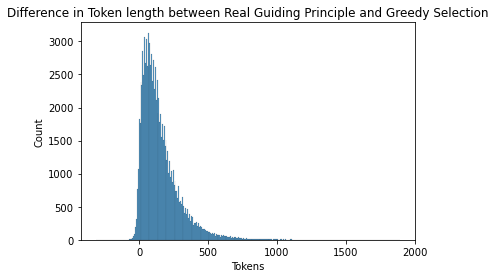

In [22]:
ax = sns.histplot(length_diff)
ax.set_title("Difference in Token length between Real Guiding Principle and Greedy Selection")
ax.set_xlabel("Tokens")

In [23]:
print("Min:", min(length_diff), "; Max:", max(length_diff), "; Average:", sum(length_diff)/len(length_diff))

Min: -315 ; Max: 1895 ; Average: 151.83045543168524


On average 152 Tokens more are approximately half a page longer than the original summarization.

In [24]:
gp_lengths = list(map(lambda x: x[0], lengths))

Text(0.5, 0, 'Tokens')

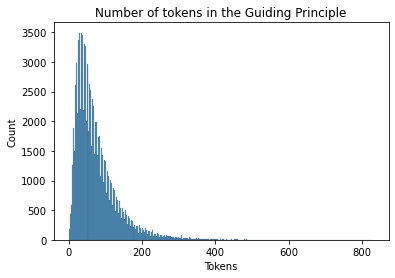

In [25]:
ax = sns.histplot(gp_lengths)
ax.set_title("Number of tokens in the Guiding Principle")
ax.set_xlabel("Tokens")

In [26]:
print("Min:", min(gp_lengths), "; Max:", max(gp_lengths), "; Average:", sum(gp_lengths)/len(gp_lengths))

Min: 1 ; Max: 830 ; Average: 75.11777233414988


In [27]:
greedy_lengths = list(map(lambda x: x[1], lengths))

Text(0.5, 0, 'Tokens')

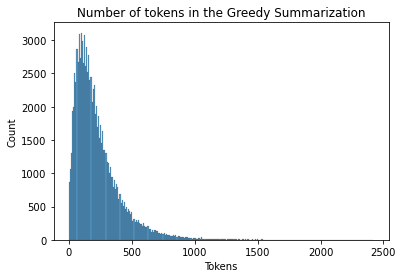

In [28]:
ax = sns.histplot(greedy_lengths)
ax.set_title("Number of tokens in the Greedy Summarization")
ax.set_xlabel("Tokens")

In [29]:
print("Min:", min(greedy_lengths), "; Max:", max(greedy_lengths), "; Average:", sum(greedy_lengths)/len(greedy_lengths))

Min: 1 ; Max: 2419 ; Average: 226.94822776583513


To summarize: On average is the Greedy Selection 3 times longer than the real summarization. Consequently it is debatable, if we can really call this a summarization, if it has on average the length of half a page.